# CRF Tutorial

  - Author: [Sébastien Mosser](mossers@mcmaster.ca)

this tutorial is _heavily inspired_ by the one provided by the original `sklearn_crfsuite` project.

## Installing the dataset

We are using the _CONLL 2002 Named Entity Recognition Corpus_ for this tutorial, available thanks to `nltk`.

In [1]:
import nltk

In [2]:
nltk.download('conll2002')

[nltk_data] Downloading package conll2002 to
[nltk_data]     /Users/mosser/nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


True

A sentence is defined as a sequence of words. Each word is a tuple (TOKEN, POS, LABEL), where:
  - TOKEN is the word, 
  - POS is the part-of-speech (grammatical role), 
  - and LAB the classified label

In [3]:
def sent2tokens(sentence): # the token available in the text
    return [tok for tok, _, _ in sentence]

def sent2pos(sentence): # Part-of-speech (grammatical) tags
    return [pos for _, pos, _ in sentence]

def sent2labels(sentence): # Label is what we are looking for
    return [label for _, _, label in sentence]

In [4]:
s = nltk.corpus.conll2002.iob_sents('esp.train')[2]
print(s)

[('El', 'DA', 'O'), ('Abogado', 'NC', 'B-PER'), ('General', 'AQ', 'I-PER'), ('del', 'SP', 'I-PER'), ('Estado', 'NC', 'I-PER'), (',', 'Fc', 'O'), ('Daryl', 'VMI', 'B-PER'), ('Williams', 'NC', 'I-PER'), (',', 'Fc', 'O'), ('subrayó', 'VMI', 'O'), ('hoy', 'RG', 'O'), ('la', 'DA', 'O'), ('necesidad', 'NC', 'O'), ('de', 'SP', 'O'), ('tomar', 'VMN', 'O'), ('medidas', 'NC', 'O'), ('para', 'SP', 'O'), ('proteger', 'VMN', 'O'), ('al', 'SP', 'O'), ('sistema', 'NC', 'O'), ('judicial', 'AQ', 'O'), ('australiano', 'AQ', 'O'), ('frente', 'RG', 'O'), ('a', 'SP', 'O'), ('una', 'DI', 'O'), ('página', 'NC', 'O'), ('de', 'SP', 'O'), ('internet', 'NC', 'O'), ('que', 'PR', 'O'), ('imposibilita', 'VMI', 'O'), ('el', 'DA', 'O'), ('cumplimiento', 'NC', 'O'), ('de', 'SP', 'O'), ('los', 'DA', 'O'), ('principios', 'NC', 'O'), ('básicos', 'AQ', 'O'), ('de', 'SP', 'O'), ('la', 'DA', 'O'), ('Ley', 'NC', 'B-MISC'), ('.', 'Fp', 'O')]


In [5]:
" ".join(sent2tokens(s))

'El Abogado General del Estado , Daryl Williams , subrayó hoy la necesidad de tomar medidas para proteger al sistema judicial australiano frente a una página de internet que imposibilita el cumplimiento de los principios básicos de la Ley .'

In [6]:
" ".join(sent2pos(s))

'DA NC AQ SP NC Fc VMI NC Fc VMI RG DA NC SP VMN NC SP VMN SP NC AQ AQ RG SP DI NC SP NC PR VMI DA NC SP DA NC AQ SP DA NC Fp'

In [7]:
" ".join(sent2labels(s))

'O B-PER I-PER I-PER I-PER O B-PER I-PER O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-MISC O'

## Extracting features from the dataset

The learning process works on _features_, which are elements used to characterize the sentence. To do this, we define a function that map each word of a given sentence into a set of elements that characterize it (is it capitalized? a digit? what is the associated POS?, ...). We also include information on the previous and next word, when they exist.

In [8]:
def word2features(sent, i):
    """ transform the i-st word in a sentence into a usable feature vector (here a dict)"""
    word = sent[i][0]
    postag = sent[i][1]

    features = { # Features for each and every word in the dataset
        'bias': 1.0,
        'word.lower()':   word.lower(),   # lower case word to harmonize -> str
        'word[-3:]':      word[-3:],      # last 3 letters -> str
        'word[-2:]':      word[-2:],      # last 2 letters -> str
        'word.isupper()': word.isupper(), # all letter upopercase -> bool
        'word.istitle()': word.istitle(), # first letter uppercase -> bool
        'word.isdigit()': word.isdigit(), # is a digit? -> bool
        'postag':         postag,         # Part-of-speech tag
        'postag[:2]':     postag[:2],     # first 2 letters of the POS tag
    }
    ## Update for words that are not the first one
    if i > 0: 
        word1 = sent[i-1][0]      # previous word
        postag1 = sent[i-1][1]    # previous POS tag
        features.update({
            '-1:word.lower()':   word1.lower(),    # Previous word spelled uniformously
            '-1:word.istitle()': word1.istitle(),  # is it a title?
            '-1:word.isupper()': word1.isupper(),  # is it upper case?
            '-1:postag':         postag1,          # POS tag for the previous word
            '-1:postag[:2]':     postag1[:2],      # first 2 letters of the previous POS tag
        })
    else:
        features['BOS'] = True # If the first one, Beginning Of Sentence is True

    # Update for words that are not the last ones
    if i < len(sent)-1:
        word1 = sent[i+1][0]   # Next word
        postag1 = sent[i+1][1] # next POS tag
        features.update({
            '+1:word.lower()':   word1.lower(),   # next word spelled uniformously
            '+1:word.istitle()': word1.istitle(), # is it a title?
            '+1:word.isupper()': word1.isupper(), # is it uppercase?
            '+1:postag':         postag1,         # next POS tag
            '+1:postag[:2]':     postag1[:2],     # first 2 letters of the POS tag
        })
    else:
        features['EOS'] = True # If the last one, then End Of Sentence is True.

    return features # return the feature vector for this very sentence

Transformign a sentence means applying this transformation to each and every word in the sentence.

In [9]:
def sent2features(sent):
    """Transform a sentences into features"""
    return [word2features(sent, i) for i in range(len(sent))]

In [10]:
print(s[0], s[1], s[2])

('El', 'DA', 'O') ('Abogado', 'NC', 'B-PER') ('General', 'AQ', 'I-PER')


In [11]:
sent2features(s)[1]

{'bias': 1.0,
 'word.lower()': 'abogado',
 'word[-3:]': 'ado',
 'word[-2:]': 'do',
 'word.isupper()': False,
 'word.istitle()': True,
 'word.isdigit()': False,
 'postag': 'NC',
 'postag[:2]': 'NC',
 '-1:word.lower()': 'el',
 '-1:word.istitle()': True,
 '-1:word.isupper()': False,
 '-1:postag': 'DA',
 '-1:postag[:2]': 'DA',
 '+1:word.lower()': 'general',
 '+1:word.istitle()': True,
 '+1:word.isupper()': False,
 '+1:postag': 'AQ',
 '+1:postag[:2]': 'AQ'}

## Extracting the training and validation datasets

In [12]:
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train')) # training sentences
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))  # test sentences

X_train = [sent2features(s) for s in train_sents] # Features for the training set
y_train = [sent2labels(s) for s in train_sents]   # expected labels

X_test = [sent2features(s) for s in test_sents]   # Features for the test set
y_test = [sent2labels(s) for s in test_sents]     # expected labels

## Training the initial model

scikit-learn comes with a `model.fit(features, labels)` function to train automatically a given `model` to predict `labels` out of `features`. We wrap this function with some engineering sugar to store the trained model and avoid unecessary training.

In [13]:
import pickle
import bz2
import os
import time

def train_model(model, x_features, y_labels, file):
    """Train model so that X fits Y, used file to store the model and avoid unnecessary training"""
    start = time.time()
    if os.path.exists(file):
        print("Loading from memory")
        with bz2.BZ2File(file, 'r') as infile:
            model = pickle.load(infile)
    else:
        print("Starting training")
        # training the model to fit the X space (features) with the Y one (labels)
        model.fit(x_features, y_labels)  ## <<== this is the training call
        print("training completed")
        with bz2.BZ2File(file, 'w') as outfile:
            print("dumping model into memory")
            pickle.dump(model, outfile)

    end = time.time()
    print('Execution time:', end-start, 'seconds')
    return model

We can now create a model describing the kind of learning algorithm we want to use.

In [14]:
from ace_sklearn_crfsuite import CRF

In [15]:
config = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf = train_model(config, X_train, y_train, "crf_model.pkl")

Loading from memory
Execution time: 0.07770800590515137 seconds


## Evaluating the model

We can now ask our trained model to _predict_ labels for the training set.

In [16]:
y_pred = crf.predict(X_test)

In our case, the `O` labels represents words that are not important in the text, so we remove them for evaluation purposes.

In [17]:
available_labels = list(crf.classes_)
available_labels.remove('O')

print("Relevant labels: " + str(available_labels))

Relevant labels: ['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']


We can now rely on scikit learn to compute metrics for us.

In [18]:
from sklearn.metrics import make_scorer, classification_report
from ace_sklearn_crfsuite import metrics

In [19]:
f1 = metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=available_labels)
print("Weighted f-measure:" + str(f1))

Weighted f-measure:0.7964686316443963


In [20]:
sorted_labels = sorted(
    available_labels,
    key=lambda name: (name[1:], name[0])
)

report = metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
)
print(report)

              precision    recall  f1-score   support

       B-LOC      0.810     0.784     0.797      1084
       I-LOC      0.690     0.637     0.662       325
      B-MISC      0.731     0.569     0.640       339
      I-MISC      0.699     0.589     0.639       557
       B-ORG      0.807     0.832     0.820      1400
       I-ORG      0.852     0.786     0.818      1104
       B-PER      0.850     0.884     0.867       735
       I-PER      0.893     0.943     0.917       634

   micro avg      0.813     0.787     0.799      6178
   macro avg      0.791     0.753     0.770      6178
weighted avg      0.809     0.787     0.796      6178



## Hyperparameter optimization (Random)

CRF uses two parameters, named `c1` and `c2`. The previous model used fixed parameter: 
  - c1=0.1
  - c2=0.1

What if we some other settings were better? We wil create a configuration that does not fix these parameter, and a _random_ exploration space to try to find better results

In [21]:
crf_hp = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True,
)

In [22]:
import scipy.stats

In [23]:
params_space = { # Isntead of fixing c1 and c2 to 0.1, we let the system explore the space to find the "best" value
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

How to define "best" results? We can consider the averaged f1-measure. We create a _scorer_ that will be used during the exploration to compare the models and keep the best one

In [24]:
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=available_labels)

We can now create a _randomized_ exploration, and let scikit-learn explore this for us.

In [25]:
from sklearn.model_selection import RandomizedSearchCV
config_rs = RandomizedSearchCV(crf_hp, params_space,
                               cv=5, verbose=100, n_jobs=-1, n_iter=50,
                               scoring=f1_scorer, 
                               return_train_score=True, refit=False)

Let's train the model! (50 candidates, with 5 folds each, means 250 training). It will take a while.

In [26]:
crf_hp = train_model(config_rs, X_train, y_train, 'crf_model_hp.pkl')

Loading from memory
Execution time: 0.005714893341064453 seconds


In [27]:
print('best params:', crf_hp.best_params_)
print('best CV score:', crf_hp.best_score_)

best params: {'c1': 0.05689423574832278, 'c2': 0.03781509311811296}
best CV score: 0.7648940338468285


## Plotting the parameter space

the obtaine model might be better (by luck), but had chances to actually be worse than our first paramneters. exploriong randomly a large space did not help. But we can use this to check where to look fur further optimization

In [28]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [29]:
def plot_hp(hp_model, color):
    _x = [s['c1'] for s in hp_model.cv_results_['params']]
    _y = [s['c2'] for s in hp_model.cv_results_['params']]
    _c = [s for s in hp_model.cv_results_[color]]

    fig = plt.figure()

    plt.scatter(_x, _y, c=_c, s=60, alpha=0.3,cmap='coolwarm')
    plt.xlabel("C1")
    plt.ylabel("C2")
    plt.title("Exploring {C1,C2} parameter space")
    cb = plt.colorbar()
    cb.ax.set_ylabel('F1-score')

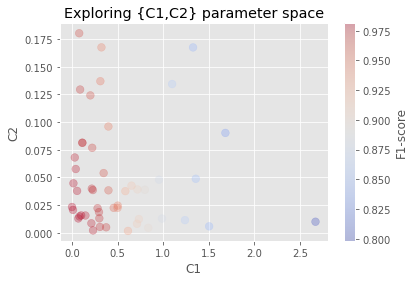

In [30]:
plot_hp(crf_hp, 'mean_train_score') # How it behave on the training sets

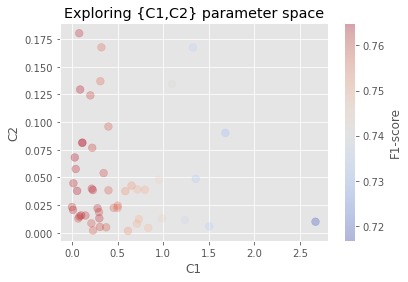

In [31]:
plot_hp(crf_hp, 'mean_test_score') # How it behave on the validation sets

So it looks like the bottom-left corner of our exploration space produces the best f-measure.

## Using a grid based search hyperparameter optimization

In [32]:
import numpy as np

In [33]:
crf_grid = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True,
)

In [34]:
params_space_grid = {
    "c1": np.linspace(0.0, 0.5, 11),
    "c2": np.linspace(0.0, 0.1, 11)
}

In [35]:
params_space_grid

{'c1': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 'c2': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])}

In [36]:
from sklearn.model_selection import GridSearchCV
config_grid = GridSearchCV(crf_grid, params_space_grid,
                               cv=5, verbose=100, n_jobs=-1,
                               scoring=f1_scorer, 
                               return_train_score=True, refit=False)

We're going to explore a space 3 times larger thjan the rendom one... it'll take a while

In [ ]:
crf_grid = train_model(config_grid, X_train, y_train, 'crf_model_grid.pkl')

Starting training
Fitting 5 folds for each of 121 candidates, totalling 605 fits
[CV 1/5; 1/121] START c1=0.0, c2=0.0............................................
[CV 1/5; 1/121] END c1=0.0, c2=0.0;, score=(train=0.913, test=0.758) total time=  44.7s
[CV 4/5; 2/121] START c1=0.0, c2=0.01...........................................
[CV 4/5; 2/121] END c1=0.0, c2=0.01;, score=(train=0.916, test=0.747) total time=  50.5s
[CV 2/5; 4/121] START c1=0.0, c2=0.03...........................................
[CV 2/5; 4/121] END c1=0.0, c2=0.03;, score=(train=0.911, test=0.742) total time=  56.4s
[CV 5/5; 5/121] START c1=0.0, c2=0.04...........................................
[CV 5/5; 5/121] END c1=0.0, c2=0.04;, score=(train=0.920, test=0.732) total time= 1.0min
[CV 4/5; 7/121] START c1=0.0, c2=0.06...........................................
[CV 4/5; 7/121] END c1=0.0, c2=0.06;, score=(train=0.916, test=0.758) total time=  52.9s
[CV 2/5; 9/121] START c1=0.0, c2=0.08.................................

/Users/mosser/.local/share/virtualenvs/tutorial-GoLrs64M/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5; 1/121] START c1=0.0, c2=0.0............................................
[CV 3/5; 1/121] END c1=0.0, c2=0.0;, score=(train=0.912, test=0.726) total time=  47.0s
[CV 5/5; 2/121] START c1=0.0, c2=0.01...........................................
[CV 5/5; 2/121] END c1=0.0, c2=0.01;, score=(train=0.922, test=0.727) total time=  52.3s
[CV 4/5; 4/121] START c1=0.0, c2=0.03...........................................
[CV 4/5; 4/121] END c1=0.0, c2=0.03;, score=(train=0.921, test=0.753) total time=  51.4s
[CV 2/5; 6/121] START c1=0.0, c2=0.05...........................................
[CV 2/5; 6/121] END c1=0.0, c2=0.05;, score=(train=0.906, test=0.742) total time= 1.0min
[CV 1/5; 8/121] START c1=0.0, c2=0.07...........................................
[CV 1/5; 8/121] END c1=0.0, c2=0.07;, score=(train=0.909, test=0.765) total time=  50.4s
[CV 3/5; 9/121] START c1=0.0, c2=0.08...........................................
[CV 3/5; 9/121] END c1=0.0, c2=0.08;, score=(train=0.917, test=0.726) 

[CV 2/5; 2/121] START c1=0.0, c2=0.01...........................................
[CV 2/5; 2/121] END c1=0.0, c2=0.01;, score=(train=0.916, test=0.728) total time=  48.9s
[CV 5/5; 3/121] START c1=0.0, c2=0.02...........................................
[CV 5/5; 3/121] END c1=0.0, c2=0.02;, score=(train=0.920, test=0.727) total time=  54.5s
[CV 3/5; 5/121] START c1=0.0, c2=0.04...........................................
[CV 3/5; 5/121] END c1=0.0, c2=0.04;, score=(train=0.917, test=0.724) total time=  48.8s
[CV 5/5; 6/121] START c1=0.0, c2=0.05...........................................
[CV 5/5; 6/121] END c1=0.0, c2=0.05;, score=(train=0.920, test=0.728) total time=  58.0s
[CV 2/5; 8/121] START c1=0.0, c2=0.07...........................................
[CV 2/5; 8/121] END c1=0.0, c2=0.07;, score=(train=0.910, test=0.733) total time=  52.9s
[CV 5/5; 9/121] START c1=0.0, c2=0.08...........................................
[CV 5/5; 9/121] END c1=0.0, c2=0.08;, score=(train=0.917, test=0.726)

[CV 3/5; 2/121] START c1=0.0, c2=0.01...........................................
[CV 3/5; 2/121] END c1=0.0, c2=0.01;, score=(train=0.920, test=0.723) total time=  47.9s
[CV 1/5; 4/121] START c1=0.0, c2=0.03...........................................
[CV 1/5; 4/121] END c1=0.0, c2=0.03;, score=(train=0.918, test=0.758) total time=  53.6s
[CV 4/5; 5/121] START c1=0.0, c2=0.04...........................................
[CV 4/5; 5/121] END c1=0.0, c2=0.04;, score=(train=0.918, test=0.761) total time=  51.0s
[CV 2/5; 7/121] START c1=0.0, c2=0.06...........................................
[CV 2/5; 7/121] END c1=0.0, c2=0.06;, score=(train=0.913, test=0.739) total time= 1.0min
[CV 5/5; 8/121] START c1=0.0, c2=0.07...........................................
[CV 5/5; 8/121] END c1=0.0, c2=0.07;, score=(train=0.918, test=0.728) total time=  51.1s
[CV 3/5; 10/121] START c1=0.0, c2=0.09..........................................
[CV 3/5; 10/121] END c1=0.0, c2=0.09;, score=(train=0.918, test=0.729

In [ ]:
print('best params:', crf_grid.best_params_)
print('best CV score:', crf_grid.best_score_)

In [ ]:
plot_hp(crf_grid, 'mean_test_score')